# Code to support the results described in " Virus detection in human metagenomic samples using machine learning"


First of all,let's import some dependencies. It would be best if you use sklearn version 0.17 or later.

In [2]:
# Load data
import sklearn
print sklearn.__version__  #it would be great if you had version 0.18
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from numpy import loadtxt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


## This is a good color scheme

tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
                 (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150), 
                 (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),   
                 (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
                 (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  

    # Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.   
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]   
    tableau20[i] = (r / 255., g / 255., b / 255.) 

tableau20 = np.array(tableau20)


0.18.1



## HELPER FUNCTIONS: 
1) Splitting into training and test set - usual random split and splitting project by project

2) Helper to get the project name from sequence ID

In [4]:
import numpy as np

#the normal random shuffle split
def TT_split(features, labels, prop=0.9):
    nr_samples = features.shape[0]
    nr_train = int(nr_samples*prop)
    indx = range(nr_samples)
    np.random.shuffle(indx)
    features_temp = features[indx,:]
    labels_temp = labels[indx]

    train_X = features_temp[:nr_train,:]
    train_Y = labels_temp[:nr_train]
    test_X = features_temp[nr_train:,:]
    test_Y = labels_temp[nr_train:]
    return train_X,train_Y,test_X,test_Y

#split by giving an array of experiment numbers and the nr to be left to the test set
def project_split(features, labels, projects, experiment_nr):
    projects =np.array(projects)
    #print "test set size", np.shape(np.where(projects == experiment_nr)[0])
    assert(len(np.where(projects != experiment_nr)[0])>0)
    
    train_X = features[np.where(projects != experiment_nr)[0]]
    train_Y = labels[np.where(projects != experiment_nr)[0]]
    test_X = features[np.where(projects == experiment_nr)[0]]
    test_Y = labels[np.where(projects == experiment_nr)[0]]
    #print "PROJECT SPLIT: total,train, test sizes", np.shape(labels),np.shape(train_Y),np.shape(test_Y)
    return train_X,train_Y,test_X,test_Y

#helper to get the project ID from the sequenceID (which is a string)
def seqID_to_projects(seqID):
    projects = np.array([x[x.find("_")+2:] for x in seqID])
    #print np.unique(projects), np.shape(np.unique(projects))
    exp_names = np.unique(projects)
    print "EXPERIMENT NAMES: "
    pr_nr = np.zeros(np.shape(projects))
    for i,name in enumerate(exp_names):
        print i, name, np.shape(np.where(projects==name))
        pr_nr[np.where(projects==name)[0]] = i
    print "\n\n\n"
    return pr_nr,exp_names

def downsample_non_virus(dataset_features, dataset_labels, downsample_to=None):
    nonvir_count, vir_count = np.bincount(dataset_labels)
    
    nr_of_non_vir = 0 
    if downsample_to > 1: # iterpret as how many samples we keep
        nr_of_non_vir = downsample_to
    elif downsample_to <1: # iterpret as how many percent of data we keep
        nr_of_non_vir = int(downsample_to * nonvir_count)

    virs = np.where(dataset_labels==1)[0]
    nonvirs = np.where(dataset_labels==0)[0]
    downsampled_nonvirs = np.random.choice(nonvirs, size= nr_of_non_vir, replace=False)
    
    downsampled_set = np.concatenate([virs, downsampled_nonvirs])

    print "downsampling", np.shape(virs), np.shape(nonvirs), np.shape(downsampled_nonvirs), np.shape(downsampled_set)
    return dataset_features[downsampled_set], dataset_labels[downsampled_set]


def upsample_virus(dataset_features, dataset_labels, upsample_ratio=1):
    if upsample_ratio <1: # iterpret as how many percent of data we keep
        assert False, "cannot downsample viruses"
    nonvir_count, vir_count = np.bincount(dataset_labels)
    
    virs = np.where(dataset_labels==1)[0]
    nonvirs = np.where(dataset_labels==0)[0]
    
    nr_of_vir = len(virs)
    nr_of_full_repetitions = int(upsample_ratio)
    nr_of_additional_vir = int(nr_of_vir*upsample_ratio) % nr_of_vir
    
    repeated_virs = virs.copy()
    for i in range(nr_of_full_repetitions-1):
        repeated_virs= np.concatenate([repeated_virs, virs])

    additional_virs = np.random.choice(virs, size= nr_of_additional_vir, replace=True)
    
    upsampled_set = np.concatenate([repeated_virs, nonvirs, additional_virs])

    print "upsampling", np.shape(virs), np.shape(nonvirs), np.shape(additional_virs), np.shape(upsampled_set)
    return dataset_features[upsampled_set], dataset_labels[upsampled_set]

# THE MAIN RESULTS:
# 1) Using only sequences that have at least 2 ORFs

We train a random forest classifier with default parameters and 100 trees (**increase this if you have time to wait**). Data comes from both strands, using sequences that have at least 2 ORFs. We use **leave-one-experiment out** type of cross validation.

In [33]:
#LEAVE ONE OUT

#WARNING RUNNING THIS CELL WILL TRAIN NEW MODELS, OLD ONES WILL BE OVERWRITTEN

#  location of the data - folder "concat_al2" does not exist and will be replaced
#  with "forward_al2" and "reverse_al2" in the loop0
f=["data/new_data/concat_al2"]

#FOR AREA UNDER CURVE
roc_probas=[]
roc_labels=[]

#do you want to get precision-recal infor for each experiment?
print_out = True

for i,folder in enumerate(f):
    print "---------#################  LEAVE ONE OUT  ###################--------\n",folder
    if "concat_al2" in folder:
        seqID1 = loadtxt(folder[:-10]+"forward_al2/RSCU_id.txt",dtype=str)
        features1 = loadtxt(folder[:-10]+"forward_al2/matrix.txt")
        labels1 = loadtxt(folder[:-10]+"forward_al2/values.txt",dtype=int)
        
        features2 = loadtxt(folder[:-10]+"reverse_al2/matrix.txt")
        labels2 = loadtxt(folder[:-10]+"reverse_al2/values.txt",dtype=int)
        seqID2 = loadtxt(folder[:-10]+"reverse_al2/RSCU_id.txt",dtype=str)

        features = np.concatenate([features1,features2])
        labels = np.concatenate([labels1,labels2])
        seqID = np.concatenate([seqID1,seqID2])
 
        projects,exp_names=seqID_to_projects(seqID)
        
    else:
        print " NOT SUPPORTED!! We do LOO only on concat_al2 right now"
        assert(False)
        
    print "overall data shape: ",features.shape, labels.shape, "\n overall counts of classes ", np.bincount(labels)
    
    for LO in range(19):
        [train_X,train_Y,test_X,test_Y] = project_split(features, labels, projects,LO)

        cc = np.bincount(test_Y)
        if len(cc)==1: #if there is only one label to be counted
            print "\n\n LOO "+str(LO)+":  there are NO VIRUSES in the test set! Skipping this experiment."
            continue # end this iteration in the for loop

        rf = RandomForestClassifier(n_estimators=100, n_jobs=4)
        
        rf.fit(train_X, train_Y)
        
        
        pred = rf.predict(test_X)
        prob = rf.predict_proba(test_X)
        
        roc_probas.append(prob)
        roc_labels.append(test_Y)     
        
        if print_out:
            print "\n\n LOO "+str(LO)+" train and test shapes after split ", train_X.shape, test_X.shape
            print "counts in test set", np.bincount(test_Y)
            report = classification_report(test_Y, pred, target_names=["not virus", "virus","not_classified"])
            print "LOO "+str(LO)+" report at 0.5: \n", report

    

---------#################  LEAVE ONE OUT  ###################--------
data/new_data/concat_al2
EXPERIMENT NAMES: 
0 011_G5_96ALL-MiSeq.fa (1, 14634)
1 011_N19_VIRASKINFAPMISEQ.fa (1, 2453)
2 013_E2_SCC.fa (1, 4553)
3 013_H4.fa (1, 2066)
4 014_B_Prostate.fa (1, 2460)
5 014_D3_Diabetes_Hyoty.fa (1, 422)
6 014_E1_30CxC.fa (1, 5768)
7 014_F1_PARAFFINBLANKBLOCKS.fa (1, 5294)
8 014_G1_MS5CASES5CONTROLS.fa (1, 9234)
9 014_G5_Hultin_MS.fa (1, 23739)
10 014_G6_Hultin_MS.fa (1, 14218)
11 014_G7_MSNEW2.fa (1, 1898)
12 014_J1_FRISKDIABETES.fa (1, 9642)
13 014_N1_Anethovirus.fa (1, 829)
14 014_O-Q1_Larynx.fa (1, 32739)
15 014_P_Lagheden_Matti-HPV-vacc-CIN3.fa (1, 8110)
16 014_R1_Hultin_Caski.fa (1, 31743)
17 015_F2_20160119.fa (1, 7479)
18 015_F_Lagheden_ACCES_HPVneg.fa (1, 11320)




overall data shape:  (188601, 59) (188601,) 
 overall counts of classes  [182936   5665]


 LOO 0 train and test shapes after split  (173967, 59) (14634, 59)
counts in test set [13649   985]
LOO 0 report at 0.5: 
   

# Macro and Micro averages of results
We now have trained a random forest for each data set and recorded the   
1)true labels  
2)predictions  
3)probabilities given to the predictions  

We can now summarize the results. We start with results at threshold 0.5.

In [34]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

print len(roc_labels)
#merge the results from experiments for micro-averaging
all_labels = np.concatenate(roc_labels)
all_labels = np.array(all_labels,dtype=int)

all_probas = np.concatenate(roc_probas)
all_preds = np.array(all_probas[:,1]>0.5,dtype=int)

report = classification_report(all_labels, all_preds, target_names=["not virus", "virus"])
print "Micro-average report at threshold 0.5: \n", report

#for macro average, we need to go experiment per experiment:

precisions_per_experiment=[]
recalls_per_experiment=[]
ROC_per_experiment = []
for i in range(len(roc_labels)):
    precisions_per_experiment.append(precision_score(roc_labels[i],np.array(roc_probas[i][:,1]>0.5,dtype=int),average=None))
    recalls_per_experiment.append(recall_score(roc_labels[i],np.array(roc_probas[i][:,1]>0.5,dtype=int),average=None))

precisions_per_experiment=np.array(precisions_per_experiment)
recalls_per_experiment=np.array(recalls_per_experiment)

# If you are in doubt, you can verify that the list above looks like the print_out in the training phase (cell above)
#print "virus precisions per experiment look correct: ", precisions_per_experiment[:,1]
#print "virus recalls per experiment look correct: ", recalls_per_experiment[:,1]

print "Macro-average precisions: [non virus, virus]: ", np.mean(precisions_per_experiment,axis=0)
print "Macro-average recalls: [non virus, virus]: ",np.mean(recalls_per_experiment,axis=0)




18
Micro-average report at threshold 0.5: 
             precision    recall  f1-score   support

  not virus       0.97      1.00      0.99    182514
      virus       0.96      0.04      0.09      5665

avg / total       0.97      0.97      0.96    188179

Macro-average precisions: [non virus, virus]:  [ 0.96090144  0.51247987]
Macro-average recalls: [non virus, virus]:  [ 0.99994595  0.03560645]


### Secondly we can see the trade-off between the precision and recall change if we change the threshold.  
 We draw:  
 1) the ROC curve  
 2) precison-recall curve

Area under the microaveraged ROC curve is:  0.715714430293
ROC for experiment nr 0 :    0.724573489142 985
ROC for experiment nr 1 :    0.488673483086 37
ROC for experiment nr 2 :    0.744285611199 328
ROC for experiment nr 3 :    0.975775193798 2
ROC for experiment nr 4 :    0.601604874173 311
ROC for experiment nr 5 :    0.645983330041 238
ROC for experiment nr 6 :    0.556545885448 295
ROC for experiment nr 7 :    0.697060418701 15
ROC for experiment nr 8 :    0.841095680957 415
ROC for experiment nr 9 :    0.842962835351 432
ROC for experiment nr 10 :    0.788265115634 224
ROC for experiment nr 11 :    0.700840376139 306
ROC for experiment nr 12 :    0.633868873742 39
ROC for experiment nr 13 :    0.8593903813 43
ROC for experiment nr 14 :    0.72839078044 180
ROC for experiment nr 15 :    0.562199052585 1451
ROC for experiment nr 16 :    0.814581119804 84
ROC for experiment nr 17 :    0.759910876035 280
Area under the macroaveraged ROC curve is:  0.72033908978


Area under the mic

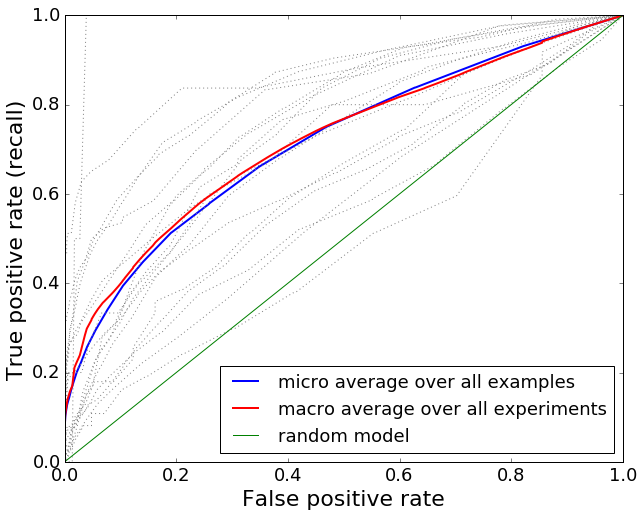

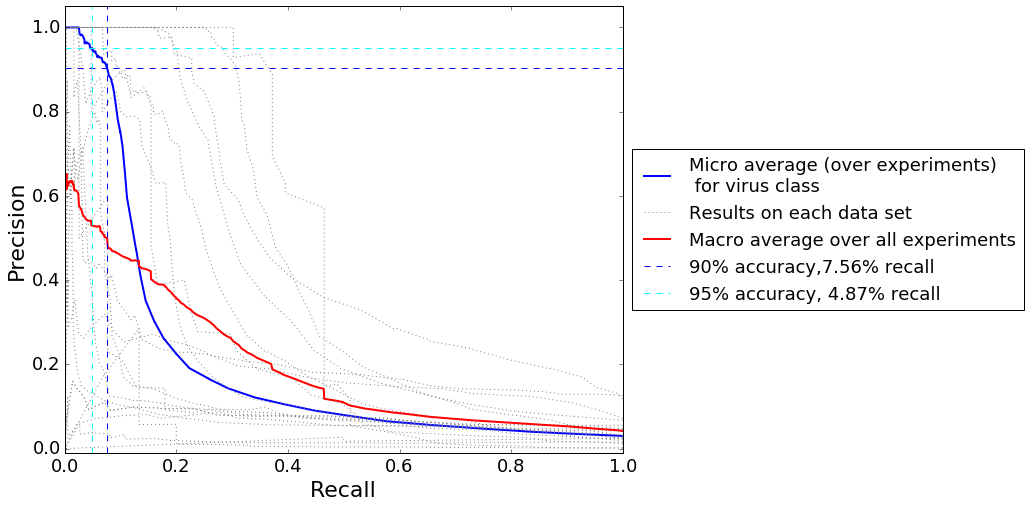

In [35]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from scipy import interp

n_experiments=18

fig = plt.figure(figsize=[10,8])


## ROC CURVE

# 1) micro averaged ROC curve is straightfowrward -concatenate true labels -> concatenate probabilities -> draw.

#all_labels = np.concatenate(roc_labels)
#all_probas = np.concatenate(roc_probas)
fpr,tpr,thresh = roc_curve(all_labels,all_probas[:,1])
plt.plot(fpr,tpr,linewidth=2,label="micro average over all examples",color="blue")

print "Area under the microaveraged ROC curve is: ", roc_auc_score(all_labels,all_probas[:,1])


# for macro average, we need to gather the TP and FP rates for each experiment individually

FP_rates=[]
TP_rates=[]

areas=[] #we also keep track of the AUC to later validate
counts=[] #also just for validation purposes

# 2) draw dotted lines for each experiment, collect the values
for i in range(n_experiments):
    #print np.shape(roc_labels[0]),np.shape(roc_probas[0][:,1])
    fpr,tpr,thresh = roc_curve(roc_labels[i],roc_probas[i][:,1])
    FP_rates.append(fpr)
    TP_rates.append(tpr)
    
    print "ROC for experiment nr",i, ":   ", roc_auc_score(roc_labels[i],roc_probas[i][:,1]), np.sum(roc_labels[i])
    plt.plot(fpr,tpr,color="gray",linestyle="dotted")
    areas.append(roc_auc_score(roc_labels[i],roc_probas[i][:,1]))
    counts.append(len(roc_labels[i]))

# 3) Compute macro-average ROC curve and ROC area

# All experiments have values in different X-coordinates, to average we need to
# interpolate between known values.
# To do this, we first aggregate all used false positive rates (X-coordinates)
all_fpr = np.unique(np.concatenate([FP_rates[i] for i in range(n_experiments)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_experiments):
    mean_tpr += interp(all_fpr, FP_rates[i], TP_rates[i])

# Finally average it and compute AUC
mean_tpr /= n_experiments
plt.plot(all_fpr,mean_tpr,linewidth=2,label="macro average over all experiments",color="red")

plt.ylabel("True positive rate (recall)",fontsize=22)
plt.xlabel("False positive rate",fontsize=22)
plt.plot([0,1],[0,1], label="random model",color="green")
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc=4,fontsize=18)

print "Area under the macroaveraged ROC curve is: ", auc(all_fpr, mean_tpr)


#
#-----------------------------------------------------------------------------
# PRECISION - RECALL curve
#-----------------------------------------------------------------------------
#

plt.figure(figsize=[10,8])
ax = plt.subplot(111)

# 1) again micro-averaging is easy:
precision_vir,recall_vir,thresh = precision_recall_curve(all_labels,all_probas[:,1])
ax.plot(recall_vir,precision_vir,color="blue",label="Micro average (over experiments)\n for virus class",linewidth=2)


# save virus and non-virus precision and recalls experiment per experiment in here
experiment_v_precs=[]
experiment_v_recs=[]
experiment_nv_precs=[]
experiment_nv_recs=[]

# 2) draw dotted lines for each experiment, collect the values
for i in range(n_experiments):
    prec_v,rec_v,thresh = precision_recall_curve(roc_labels[i],roc_probas[i][:,1])
    prec_nv,rec_nv,thresh = precision_recall_curve(np.abs(roc_labels[i]-1),roc_probas[i][:,0])
    experiment_v_precs.append(prec_v)
    experiment_v_recs.append(rec_v)
    experiment_nv_precs.append(prec_nv)
    experiment_nv_recs.append(rec_nv)

    ax.plot(rec_v,prec_v,color="gray",linestyle="dotted")

#draw the last line again, simply to make an entry to the legend
ax.plot(rec_v,prec_v,color="gray",linestyle="dotted",label="Results on each data set")



# 3) Compute macro-average precision-recall curve and AUC

# All experiments have values in different X-coordinates, to get an average we need to
# interpolate between known values.

# To do this, we first aggregate all used recall rates (X-coordinates)
all_v_rec = np.unique(np.concatenate([experiment_v_recs[i] for i in range(n_experiments)]))

# Then interpolate all ROC curves at these points
mean_precisions = np.zeros_like(all_v_rec)
for i in range(n_experiments):
    # NOTICE: to use interpolate, the x-axis values need to be sorted increasingly,
    # so we need to reverse the arrays
    mean_precisions += interp(all_v_rec, experiment_v_recs[i][::-1], experiment_v_precs[i][::-1])


    # Finally average it and compute AUC
mean_precisions /= n_experiments
plt.plot(all_v_rec,mean_precisions,linewidth=2,label="Macro average over all experiments",color="red")


print "\n\nArea under the micro-averaged PRECISION-REC curve is:", auc(recall_vir,precision_vir)
print "Area under the macro-averaged PRECISION-REC curve is: ", auc(all_v_rec, mean_precisions)


ax.set_xlabel('Recall',fontsize=22)
ax.set_ylabel('Precision',fontsize=22)
ax.set_ylim([-0.01, 1.05])
ax.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax.tick_params(axis='both', labelsize=18)
ax.set_xlim([0.0, 1.0])
#plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision[0]))

# 4) we also add lines to the plot do demonstate the trade-off at certain values 
id74 = np.min(np.where(precision_vir>0.74)[0])
print "at precision 0.74  ", precision_vir[id74]," we have recall of: ",recall_vir[id74]
id90 = np.min(np.where(precision_vir>0.9)[0])
print "at precision 0.9  ", precision_vir[id90]," we have recall of: ",recall_vir[id90]
id95 = np.min(np.where(precision_vir>0.95)[0])
print "at precision 0.95  ",precision_vir[id95]," we have recall of: ",recall_vir[id95]
ax.axhline(precision_vir[id90],linestyle="--",label="90% accuracy,"+str(np.round(recall_vir[id90],4)*100)+"% recall")
ax.axvline(recall_vir[id90],linestyle="--")
ax.axhline(precision_vir[id95],color="cyan",linestyle="--",label="95% accuracy, "+str(np.round(recall_vir[id95],4)*100)+"% recall")
ax.axvline(recall_vir[id95],color="cyan",linestyle="--")
ax.legend(loc="center left",bbox_to_anchor=(1,0.5),fontsize=18)

plt.show()


## TESTING DOWNSAMPLING

In [10]:
#LEAVE ONE OUT

#WARNING RUNNING THIS CELL WILL TRAIN NEW MODELS, OLD ONES WILL BE OVERWRITTEN

#  location of the data - folder "concat_al2" does not exist and will be replaced
#  with "forward_al2" and "reverse_al" in the loop0
f=["data/new_data/concat_al2"]

#FOR AREA UNDER CURVE
roc_probas=[]
roc_labels=[]

#do you want to get precision-recal infor for each experiment?
print_out = True

for i,folder in enumerate(f):
    print "---------#################  LEAVE ONE OUT  ###################--------\n",folder
    if "concat_al2" in folder:
        seqID1 = loadtxt(folder[:-10]+"forward_al2/RSCU_id.txt",dtype=str)
        features1 = loadtxt(folder[:-10]+"forward_al2/matrix.txt")
        labels1 = loadtxt(folder[:-10]+"forward_al2/values.txt",dtype=int)
        
        features2 = loadtxt(folder[:-10]+"reverse_al2/matrix.txt")
        labels2 = loadtxt(folder[:-10]+"reverse_al2/values.txt",dtype=int)
        seqID2 = loadtxt(folder[:-10]+"reverse_al2/RSCU_id.txt",dtype=str)

        features = np.concatenate([features1,features2])
        labels = np.concatenate([labels1,labels2])
        seqID = np.concatenate([seqID1,seqID2])
 
        projects,exp_names=seqID_to_projects(seqID)
        
    else:
        print " NOT SUPPORTED!! We do LOO only on concat_al2 right now"
        assert(False)
        
    print "overall data shape: ",features.shape, labels.shape, "\n overall counts of classes ", np.bincount(labels)
    
    for LO in range(19):
        print "Project ", LO, "\n"
        [train_X,train_Y,test_X,test_Y] = project_split(features, labels, projects,LO)
        
        print "before downsample", np.shape(train_X),np.shape(train_Y)
        # in here we downsample the "non-virus" calss in training set
        train_X,train_Y = downsample_non_virus(train_X,train_Y, downsample_to=0.5)
        print "after downsample", np.shape(train_X),np.shape(train_Y)


        cc = np.bincount(test_Y)
        if len(cc)==1: #if there is only one label to be counted
            print "\n\n LOO "+str(LO)+":  there are NO VIRUSES in the test set! Skipping this experiment."
            continue # end this iteration in the for loop

        rf = RandomForestClassifier(n_estimators=100, n_jobs=3)
        
        rf.fit(train_X, train_Y)
        
        
        pred = rf.predict(test_X)
        prob = rf.predict_proba(test_X)
        
        roc_probas.append(prob)
        roc_labels.append(test_Y)     
        
        if print_out:
            print "\n\n LOO "+str(LO)+" train and test shapes after split ", train_X.shape, test_X.shape
            print "counts in test set", np.bincount(test_Y)
            report = classification_report(test_Y, pred, target_names=["not virus", "virus","not_classified"])
            print "LOO "+str(LO)+" report at 0.5: \n", report
            #print rf.oob_score

    

---------#################  LEAVE ONE OUT  ###################--------
data/new_data/concat_al2
EXPERIMENT NAMES: 
0 011_G5_96ALL-MiSeq.fa (1, 14634)
1 011_N19_VIRASKINFAPMISEQ.fa (1, 2453)
2 013_E2_SCC.fa (1, 4553)
3 013_H4.fa (1, 2066)
4 014_B_Prostate.fa (1, 2460)
5 014_D3_Diabetes_Hyoty.fa (1, 422)
6 014_E1_30CxC.fa (1, 5768)
7 014_F1_PARAFFINBLANKBLOCKS.fa (1, 5294)
8 014_G1_MS5CASES5CONTROLS.fa (1, 9234)
9 014_G5_Hultin_MS.fa (1, 23739)
10 014_G6_Hultin_MS.fa (1, 14218)
11 014_G7_MSNEW2.fa (1, 1898)
12 014_J1_FRISKDIABETES.fa (1, 9642)
13 014_N1_Anethovirus.fa (1, 829)
14 014_O-Q1_Larynx.fa (1, 32739)
15 014_P_Lagheden_Matti-HPV-vacc-CIN3.fa (1, 8110)
16 014_R1_Hultin_Caski.fa (1, 31743)
17 015_F2_20160119.fa (1, 7479)
18 015_F_Lagheden_ACCES_HPVneg.fa (1, 11320)




overall data shape:  (188601, 59) (188601,) 
 overall counts of classes  [182936   5665]
Project  0 

before downsample (173967, 59) (173967,)
downsampling (4680,) (169287,) (84643,) (89323,)
after downsample (89323,

In [11]:
print len(roc_labels)
#merge the results from experiments for micro-averaging
all_labels = np.concatenate(roc_labels)
all_labels = np.array(all_labels,dtype=int)

all_probas = np.concatenate(roc_probas)
all_preds = np.array(all_probas[:,1]>0.5,dtype=int)

report = classification_report(all_labels, all_preds, target_names=["not virus", "virus"])
print "Micro-average report at threshold 0.5: \n", report

#for macro average, we need to go experiment per experiment:

precisions_per_experiment=[]
recalls_per_experiment=[]
for i in range(len(roc_labels)):
    precisions_per_experiment.append(precision_score(roc_labels[i],np.array(roc_probas[i][:,1]>0.5,dtype=int),average=None))
    recalls_per_experiment.append(recall_score(roc_labels[i],np.array(roc_probas[i][:,1]>0.5,dtype=int),average=None))

precisions_per_experiment=np.array(precisions_per_experiment)
recalls_per_experiment=np.array(recalls_per_experiment)

# If you are in doubt, you can verify that the list above looks like the print_out in the training phase (cell above)
#print "virus precisions per experiment look correct: ", precisions_per_experiment[:,1]
#print "virus recalls per experiment look correct: ", recalls_per_experiment[:,1]

print "Macro-average precisions: [non virus, virus]: ", np.mean(precisions_per_experiment,axis=0)
print "Macro-average recalls: [non virus, virus]: ",np.mean(recalls_per_experiment,axis=0)




18
Micro-average report at threshold 0.5: 
             precision    recall  f1-score   support

  not virus       0.97      1.00      0.99    182514
      virus       0.92      0.06      0.12      5665

avg / total       0.97      0.97      0.96    188179

Macro-average precisions: [non virus, virus]:  [ 0.96150781  0.49054946]
Macro-average recalls: [non virus, virus]:  [ 0.99984417  0.05388154]


Area under the microaveraged ROC curve is:  0.735892421257
Area under the macroaveraged ROC curve is:  0.740202502335


Area under the micro-averaged PRECISION-REC curve is: 0.196655677692
Area under the macro-averaged PRECISION-REC curve is:  0.219006835858
at precision 0.74   0.751085383502  we have recall of:  0.0916151809356
at precision 0.9   0.900677200903  we have recall of:  0.0704324801412
at precision 0.95   0.95041322314  we have recall of:  0.0406001765225


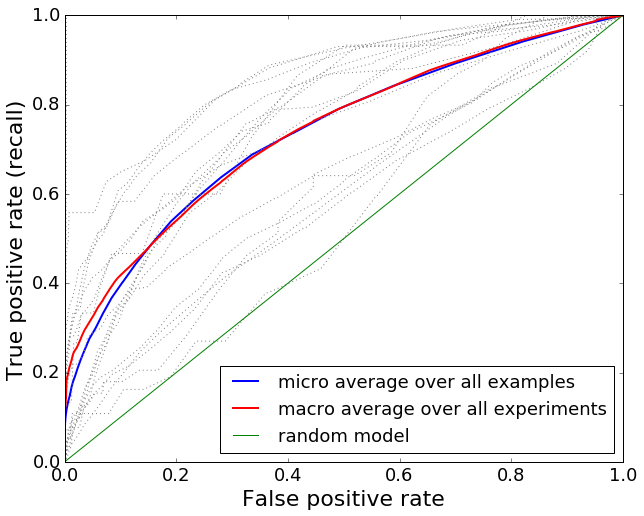

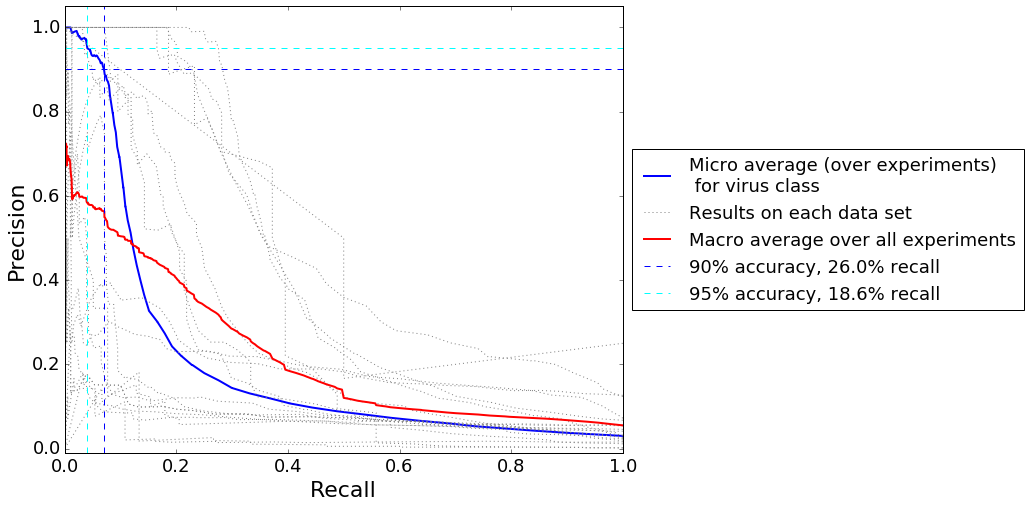

In [12]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from scipy import interp

n_experiments=18

fig = plt.figure(figsize=[10,8])


## ROC CURVE

# 1) micro averaged ROC curve is straightfowrward -concatenate true labels -> concatenate probabilities -> draw.

all_labels = np.concatenate(roc_labels)
all_probas = np.concatenate(roc_probas)
fpr,tpr,thresh = roc_curve(all_labels,all_probas[:,1])
plt.plot(fpr,tpr,linewidth=2,label="micro average over all examples",color="blue")

print "Area under the microaveraged ROC curve is: ", roc_auc_score(all_labels,all_probas[:,1])


# for macro average, we need to gather the TP and FP rates for each experiment individually

FP_rates=[]
TP_rates=[]

areas=[] #we also keep track of the AUC to later validate
counts=[] #also just for validation purposes

# 2) draw dotted lines for each experiment, collect the values
for i in range(n_experiments):
    #print np.shape(roc_labels[0]),np.shape(roc_probas[0][:,1])
    fpr,tpr,thresh = roc_curve(roc_labels[i],roc_probas[i][:,1])
    FP_rates.append(fpr)
    TP_rates.append(tpr)
    
    #print roc_auc_score(roc_labels[i],roc_probas[i][:,1])
    plt.plot(fpr,tpr,color="gray",linestyle="dotted")
    areas.append(roc_auc_score(roc_labels[i],roc_probas[i][:,1]))
    counts.append(len(roc_labels[i]))



# 3) Compute macro-average ROC curve and ROC area

# All experiments have values in different X-coordinates, to average we need to
# interpolate between known values.
# To do this, we first aggregate all used false positive rates (X-coordinates)
all_fpr = np.unique(np.concatenate([FP_rates[i] for i in range(n_experiments)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_experiments):
    mean_tpr += interp(all_fpr, FP_rates[i], TP_rates[i])

# Finally average it and compute AUC
mean_tpr /= n_experiments
plt.plot(all_fpr,mean_tpr,linewidth=2,label="macro average over all experiments",color="red")

plt.ylabel("True positive rate (recall)",fontsize=22)
plt.xlabel("False positive rate",fontsize=22)
plt.plot([0,1],[0,1], label="random model",color="green")
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc=4,fontsize=18)

print "Area under the macroaveraged ROC curve is: ", auc(all_fpr, mean_tpr)


#
#-----------------------------------------------------------------------------
# PRECISION - RECALL curve
#-----------------------------------------------------------------------------
#

plt.figure(figsize=[10,8])
ax = plt.subplot(111)

# 1) again micro-averaging is easy:
precision_vir,recall_vir,thresh = precision_recall_curve(all_labels,all_probas[:,1])
ax.plot(recall_vir,precision_vir,color="blue",label="Micro average (over experiments)\n for virus class",linewidth=2)


# save virus and non-virus precision and recalls experiment per experiment in here
experiment_v_precs=[]
experiment_v_recs=[]
experiment_nv_precs=[]
experiment_nv_recs=[]

# 2) draw dotted lines for each experiment, collect the values
for i in range(n_experiments):
    prec_v,rec_v,thresh = precision_recall_curve(roc_labels[i],roc_probas[i][:,1])
    prec_nv,rec_nv,thresh = precision_recall_curve(np.abs(roc_labels[i]-1),roc_probas[i][:,0])
    experiment_v_precs.append(prec_v)
    experiment_v_recs.append(rec_v)
    experiment_nv_precs.append(prec_nv)
    experiment_nv_recs.append(rec_nv)

    ax.plot(rec_v,prec_v,color="gray",linestyle="dotted")

#draw the last line again, simply to make an entry to the legend
ax.plot(rec_v,prec_v,color="gray",linestyle="dotted",label="Results on each data set")



# 3) Compute macro-average precision-recall curve and AUC

# All experiments have values in different X-coordinates, to get an average we need to
# interpolate between known values.

# To do this, we first aggregate all used recall rates (X-coordinates)
all_v_rec = np.unique(np.concatenate([experiment_v_recs[i] for i in range(n_experiments)]))

# Then interpolate all ROC curves at these points
mean_precisions = np.zeros_like(all_v_rec)
for i in range(n_experiments):
    # NOTICE: to use interpolate, the x-axis values need to be sorted increasingly,
    # so we need to reverse the arrays
    mean_precisions += interp(all_v_rec, experiment_v_recs[i][::-1], experiment_v_precs[i][::-1])


    # Finally average it and compute AUC
mean_precisions /= n_experiments
plt.plot(all_v_rec,mean_precisions,linewidth=2,label="Macro average over all experiments",color="red")


print "\n\nArea under the micro-averaged PRECISION-REC curve is:", auc(recall_vir,precision_vir)
print "Area under the macro-averaged PRECISION-REC curve is: ", auc(all_v_rec, mean_precisions)


ax.set_xlabel('Recall',fontsize=22)
ax.set_ylabel('Precision',fontsize=22)
ax.set_ylim([-0.01, 1.05])
ax.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax.tick_params(axis='both', labelsize=18)
ax.set_xlim([0.0, 1.0])
#plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision[0]))

# 4) we also add lines to the plot do demonstate the trade-off at certain values 
id74 = np.min(np.where(precision_vir>0.74)[0])
print "at precision 0.74  ", precision_vir[id74]," we have recall of: ",recall_vir[id74]
id90 = np.min(np.where(precision_vir>0.9)[0])
print "at precision 0.9  ", precision_vir[id90]," we have recall of: ",recall_vir[id90]
id95 = np.min(np.where(precision_vir>0.95)[0])
print "at precision 0.95  ",precision_vir[id95]," we have recall of: ",recall_vir[id95]
ax.axhline(precision_vir[id90],linestyle="--",label="90% accuracy, 26.0% recall")
ax.axvline(recall_vir[id90],linestyle="--")
ax.axhline(precision_vir[id95],color="cyan",linestyle="--",label="95% accuracy, 18.6% recall")
ax.axvline(recall_vir[id95],color="cyan",linestyle="--")
ax.legend(loc="center left",bbox_to_anchor=(1,0.5),fontsize=18)

plt.show()



## UPSAMPLING

In [13]:
#LEAVE ONE OUT

#WARNING RUNNING THIS CELL WILL TRAIN NEW MODELS, OLD ONES WILL BE OVERWRITTEN

#  location of the data - folder "concat_al2" does not exist and will be replaced
#  with "forward_al2" and "reverse_al" in the loop0
f=["data/new_data/concat_al2"]

#FOR AREA UNDER CURVE
roc_probas=[]
roc_labels=[]

used_projects =[]

#do you want to get precision-recal infor for each experiment?
print_out = True

for i,folder in enumerate(f):
    print "---------#################  LEAVE ONE OUT  ###################--------\n",folder
    if "concat_al2" in folder:
        seqID1 = loadtxt(folder[:-10]+"forward_al2/RSCU_id.txt",dtype=str)
        features1 = loadtxt(folder[:-10]+"forward_al2/matrix.txt")
        labels1 = loadtxt(folder[:-10]+"forward_al2/values.txt",dtype=int)
        
        features2 = loadtxt(folder[:-10]+"reverse_al2/matrix.txt")
        labels2 = loadtxt(folder[:-10]+"reverse_al2/values.txt",dtype=int)
        seqID2 = loadtxt(folder[:-10]+"reverse_al2/RSCU_id.txt",dtype=str)

        features = np.concatenate([features1,features2])
        labels = np.concatenate([labels1,labels2])
        seqID = np.concatenate([seqID1,seqID2])
 
        projects,exp_names=seqID_to_projects(seqID)
        
    else:
        print " NOT SUPPORTED!! We do LOO only on concat_al2 right now"
        assert(False)
        
    print "overall data shape: ",features.shape, labels.shape, "\n overall counts of classes ", np.bincount(labels)
    
    for LO in range(19):
        print "Project ", LO, "\n"
        [train_X,train_Y,test_X,test_Y] = project_split(features, labels, projects,LO)
        
        print "before upsampling ", np.shape(train_X),np.shape(train_Y) , np.bincount(train_Y)
        # in here we downsample the "non-virus" calss in training set
        train_X,train_Y = upsample_virus(train_X,train_Y, upsample_ratio=4)
        print "after upsampling  ", np.shape(train_X),np.shape(train_Y),  np.bincount(train_Y)


        cc = np.bincount(test_Y)
        if len(cc)==1: #if there is only one label to be counted
            print "\n\n LOO "+str(LO)+":  there are NO VIRUSES in the test set! Skipping this experiment."
            continue # end this iteration in the for loop

        used_projects.append(exp_names[LO])
        rf = RandomForestClassifier(class_weight="balanced",n_estimators=100,n_jobs=3)
        
        rf.fit(train_X, train_Y)
        
        
        pred = rf.predict(test_X)
        prob = rf.predict_proba(test_X)        
        roc_probas.append(prob)
        roc_labels.append(test_Y)     
        
        if print_out:
            print "\n\n LOO "+str(LO)+" train and test shapes after split ", train_X.shape, test_X.shape
            print "counts in test set", np.bincount(test_Y)
            report = classification_report(test_Y, pred, target_names=["not virus", "virus","not_classified"])
            print "LOO "+str(LO)+" report at 0.5: \n", report
            #print rf.oob_score

print used_projects    

---------#################  LEAVE ONE OUT  ###################--------
data/new_data/concat_al2
EXPERIMENT NAMES: 
0 011_G5_96ALL-MiSeq.fa (1, 14634)
1 011_N19_VIRASKINFAPMISEQ.fa (1, 2453)
2 013_E2_SCC.fa (1, 4553)
3 013_H4.fa (1, 2066)
4 014_B_Prostate.fa (1, 2460)
5 014_D3_Diabetes_Hyoty.fa (1, 422)
6 014_E1_30CxC.fa (1, 5768)
7 014_F1_PARAFFINBLANKBLOCKS.fa (1, 5294)
8 014_G1_MS5CASES5CONTROLS.fa (1, 9234)
9 014_G5_Hultin_MS.fa (1, 23739)
10 014_G6_Hultin_MS.fa (1, 14218)
11 014_G7_MSNEW2.fa (1, 1898)
12 014_J1_FRISKDIABETES.fa (1, 9642)
13 014_N1_Anethovirus.fa (1, 829)
14 014_O-Q1_Larynx.fa (1, 32739)
15 014_P_Lagheden_Matti-HPV-vacc-CIN3.fa (1, 8110)
16 014_R1_Hultin_Caski.fa (1, 31743)
17 015_F2_20160119.fa (1, 7479)
18 015_F_Lagheden_ACCES_HPVneg.fa (1, 11320)




overall data shape:  (188601, 59) (188601,) 
 overall counts of classes  [182936   5665]
Project  0 

before upsampling  (173967, 59) (173967,) [169287   4680]
upsampling (4680,) (169287,) (0,) (188007,)
after upsamp

In [14]:
print used_projects
labels_from_LOEO = np.concatenate(roc_labels)
print np.shape(labels_from_LOEO)
used_lines = []
used_seqs = []
for i,one_seqID in enumerate(seqID):
    if any(substring in one_seqID for substring in used_projects):
        used_lines.append(i)
        used_seqs.append(one_seqID)
        
print np.shape(used_seqs)
print np.all(np.array(labels[used_lines])==labels_from_LOEO)
print np.sum(labels_from_LOEO), np.sum(labels[used_lines])
#for i in range(len(labels_from_LOEO)):
#    if not labels_from_LOEO[i] == labels[used_lines[i]]:
#        print labels_from_LOEO[i], labels[used_lines[i]], used_seqs[i]

['011_G5_96ALL-MiSeq.fa', '011_N19_VIRASKINFAPMISEQ.fa', '013_E2_SCC.fa', '013_H4.fa', '014_B_Prostate.fa', '014_E1_30CxC.fa', '014_F1_PARAFFINBLANKBLOCKS.fa', '014_G1_MS5CASES5CONTROLS.fa', '014_G5_Hultin_MS.fa', '014_G6_Hultin_MS.fa', '014_G7_MSNEW2.fa', '014_J1_FRISKDIABETES.fa', '014_N1_Anethovirus.fa', '014_O-Q1_Larynx.fa', '014_P_Lagheden_Matti-HPV-vacc-CIN3.fa', '014_R1_Hultin_Caski.fa', '015_F2_20160119.fa', '015_F_Lagheden_ACCES_HPVneg.fa']
(188179,)
(188179,)
False
5665 5665


In [15]:
print len(roc_labels)
#merge the results from experiments for micro-averaging
all_labels = np.concatenate(roc_labels)
all_labels = np.array(all_labels,dtype=int)

all_probas = np.concatenate(roc_probas)
all_preds = np.array(all_probas[:,1]>0.5,dtype=int)

report = classification_report(all_labels, all_preds, target_names=["not virus", "virus"])
print "Micro-average report at threshold 0.5: \n", report


#np.savetxt("predictions_true.txt",np.concatenate() fmt="%s %d %d")
#for macro average, we need to go experiment per experiment:

precisions_per_experiment=[]
recalls_per_experiment=[]
for i in range(len(roc_labels)):
    precisions_per_experiment.append(precision_score(roc_labels[i],np.array(roc_probas[i][:,1]>0.5,dtype=int),average=None))
    recalls_per_experiment.append(recall_score(roc_labels[i],np.array(roc_probas[i][:,1]>0.5,dtype=int),average=None))

precisions_per_experiment=np.array(precisions_per_experiment)
recalls_per_experiment=np.array(recalls_per_experiment)

# If you are in doubt, you can verify that the list above looks like the print_out in the training phase (cell above)
#print "virus precisions per experiment look correct: ", precisions_per_experiment[:,1]
#print "virus recalls per experiment look correct: ", recalls_per_experiment[:,1]

print "Macro-average precisions: [non virus, virus]: ", np.mean(precisions_per_experiment,axis=0)
print "Macro-average recalls: [non virus, virus]: ",np.mean(recalls_per_experiment,axis=0)




18
Micro-average report at threshold 0.5: 
             precision    recall  f1-score   support

  not virus       0.97      1.00      0.99    182514
      virus       0.84      0.06      0.12      5665

avg / total       0.97      0.97      0.96    188179

Macro-average precisions: [non virus, virus]:  [ 0.96166679  0.61402182]
Macro-average recalls: [non virus, virus]:  [ 0.99957399  0.05782553]


Area under the microaveraged ROC curve is:  0.753821381399
Area under the macroaveraged ROC curve is:  0.751133855714


Area under the micro-averaged PRECISION-REC curve is: 0.20250152764
Area under the macro-averaged PRECISION-REC curve is:  0.212325239226
at precision 0.74   0.752542372881  we have recall of:  0.0783759929391
at precision 0.9   0.902597402597  we have recall of:  0.0490732568402
at precision 0.95   0.953608247423  we have recall of:  0.0326566637246


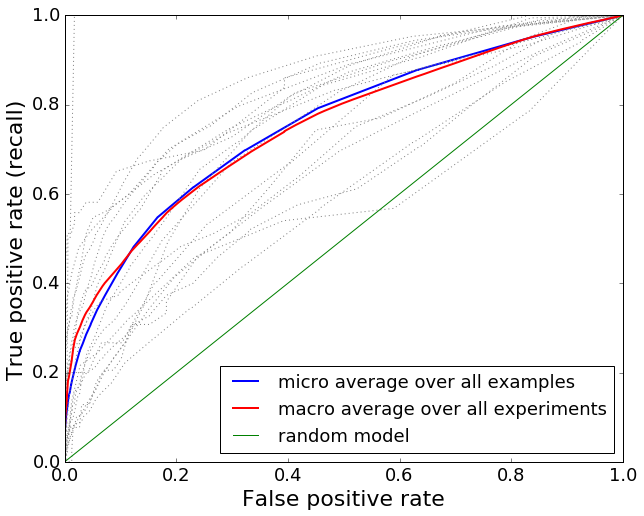

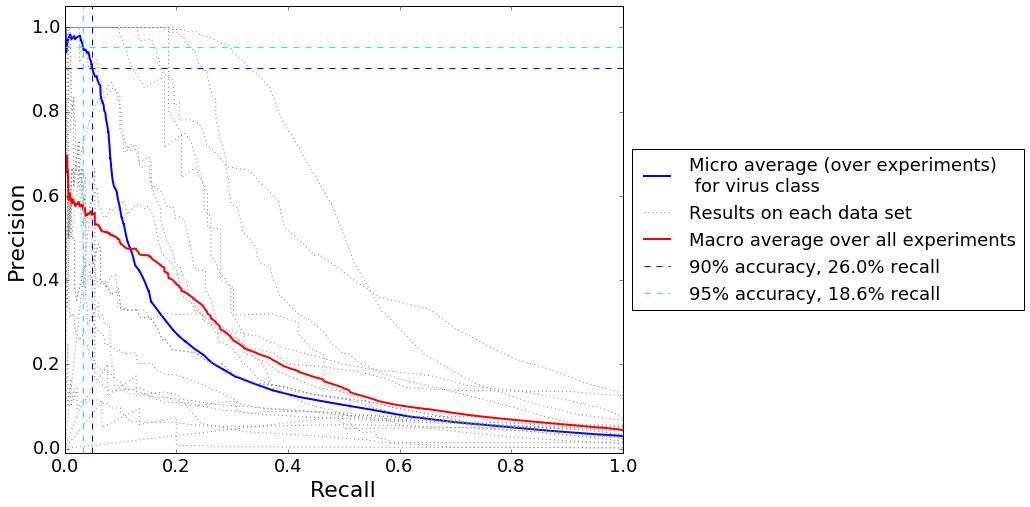

In [16]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from scipy import interp

n_experiments=18

fig = plt.figure(figsize=[10,8])


## ROC CURVE

# 1) micro averaged ROC curve is straightfowrward -concatenate true labels -> concatenate probabilities -> draw.

all_labels = np.concatenate(roc_labels)
all_probas = np.concatenate(roc_probas)
fpr,tpr,thresh = roc_curve(all_labels,all_probas[:,1])
plt.plot(fpr,tpr,linewidth=2,label="micro average over all examples",color="blue")

print "Area under the microaveraged ROC curve is: ", roc_auc_score(all_labels,all_probas[:,1])


# for macro average, we need to gather the TP and FP rates for each experiment individually

FP_rates=[]
TP_rates=[]

areas=[] #we also keep track of the AUC to later validate
counts=[] #also just for validation purposes

# 2) draw dotted lines for each experiment, collect the values
for i in range(n_experiments):
    #print np.shape(roc_labels[0]),np.shape(roc_probas[0][:,1])
    fpr,tpr,thresh = roc_curve(roc_labels[i],roc_probas[i][:,1])
    FP_rates.append(fpr)
    TP_rates.append(tpr)
    
    #print roc_auc_score(roc_labels[i],roc_probas[i][:,1])
    plt.plot(fpr,tpr,color="gray",linestyle="dotted")
    areas.append(roc_auc_score(roc_labels[i],roc_probas[i][:,1]))
    counts.append(len(roc_labels[i]))



# 3) Compute macro-average ROC curve and ROC area

# All experiments have values in different X-coordinates, to average we need to
# interpolate between known values.
# To do this, we first aggregate all used false positive rates (X-coordinates)
all_fpr = np.unique(np.concatenate([FP_rates[i] for i in range(n_experiments)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_experiments):
    mean_tpr += interp(all_fpr, FP_rates[i], TP_rates[i])

# Finally average it and compute AUC
mean_tpr /= n_experiments
plt.plot(all_fpr,mean_tpr,linewidth=2,label="macro average over all experiments",color="red")

plt.ylabel("True positive rate (recall)",fontsize=22)
plt.xlabel("False positive rate",fontsize=22)
plt.plot([0,1],[0,1], label="random model",color="green")
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc=4,fontsize=18)

print "Area under the macroaveraged ROC curve is: ", auc(all_fpr, mean_tpr)


#
#-----------------------------------------------------------------------------
# PRECISION - RECALL curve
#-----------------------------------------------------------------------------
#

plt.figure(figsize=[10,8])
ax = plt.subplot(111)

# 1) again micro-averaging is easy:
precision_vir,recall_vir,thresh = precision_recall_curve(all_labels,all_probas[:,1])
ax.plot(recall_vir,precision_vir,color="blue",label="Micro average (over experiments)\n for virus class",linewidth=2)


# save virus and non-virus precision and recalls experiment per experiment in here
experiment_v_precs=[]
experiment_v_recs=[]
experiment_nv_precs=[]
experiment_nv_recs=[]

# 2) draw dotted lines for each experiment, collect the values
for i in range(n_experiments):
    prec_v,rec_v,thresh = precision_recall_curve(roc_labels[i],roc_probas[i][:,1])
    prec_nv,rec_nv,thresh = precision_recall_curve(np.abs(roc_labels[i]-1),roc_probas[i][:,0])
    experiment_v_precs.append(prec_v)
    experiment_v_recs.append(rec_v)
    experiment_nv_precs.append(prec_nv)
    experiment_nv_recs.append(rec_nv)

    ax.plot(rec_v,prec_v,color="gray",linestyle="dotted")

#draw the last line again, simply to make an entry to the legend
ax.plot(rec_v,prec_v,color="gray",linestyle="dotted",label="Results on each data set")



# 3) Compute macro-average precision-recall curve and AUC

# All experiments have values in different X-coordinates, to get an average we need to
# interpolate between known values.

# To do this, we first aggregate all used recall rates (X-coordinates)
all_v_rec = np.unique(np.concatenate([experiment_v_recs[i] for i in range(n_experiments)]))

# Then interpolate all ROC curves at these points
mean_precisions = np.zeros_like(all_v_rec)
for i in range(n_experiments):
    # NOTICE: to use interpolate, the x-axis values need to be sorted increasingly,
    # so we need to reverse the arrays
    mean_precisions += interp(all_v_rec, experiment_v_recs[i][::-1], experiment_v_precs[i][::-1])


    # Finally average it and compute AUC
mean_precisions /= n_experiments
plt.plot(all_v_rec,mean_precisions,linewidth=2,label="Macro average over all experiments",color="red")


print "\n\nArea under the micro-averaged PRECISION-REC curve is:", auc(recall_vir,precision_vir)
print "Area under the macro-averaged PRECISION-REC curve is: ", auc(all_v_rec, mean_precisions)


ax.set_xlabel('Recall',fontsize=22)
ax.set_ylabel('Precision',fontsize=22)
ax.set_ylim([-0.01, 1.05])
ax.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax.tick_params(axis='both', labelsize=18)
ax.set_xlim([0.0, 1.0])
#plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision[0]))

# 4) we also add lines to the plot do demonstate the trade-off at certain values 
id74 = np.min(np.where(precision_vir>0.74)[0])
print "at precision 0.74  ", precision_vir[id74]," we have recall of: ",recall_vir[id74]
id90 = np.min(np.where(precision_vir>0.9)[0])
print "at precision 0.9  ", precision_vir[id90]," we have recall of: ",recall_vir[id90]
id95 = np.min(np.where(precision_vir>0.95)[0])
print "at precision 0.95  ",precision_vir[id95]," we have recall of: ",recall_vir[id95]
ax.axhline(precision_vir[id90],linestyle="--",label="90% accuracy, 26.0% recall")
ax.axvline(recall_vir[id90],linestyle="--")
ax.axhline(precision_vir[id95],color="cyan",linestyle="--",label="95% accuracy, 18.6% recall")
ax.axvline(recall_vir[id95],color="cyan",linestyle="--")
ax.legend(loc="center left",bbox_to_anchor=(1,0.5),fontsize=18)

plt.show()



## FEATURE IMPORTANCE
When studying feature importance we do not care about precision or recall or overfitting. We do not even need a test set. This means we do not need to work with leave-one-experiment-out approach and average over 18 models. Instead we just take the whole data set as training data.  
<br>
We use a larger number of trees, because we want to get a good average of the importances of features over many trees.

In [17]:
feature_forest = RandomForestClassifier(n_estimators=1000,class_weight="balanced", n_jobs=3)
print features.shape
feature_forest.fit(features, labels)

(188601, 59)


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=3,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

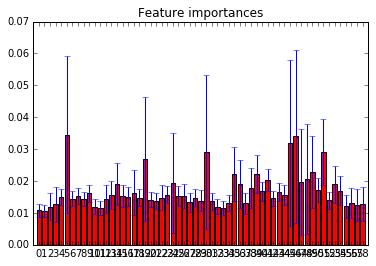

[0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 9, 9, 9, 9, 10, 10, 11, 11, 11, 12, 12, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 17, 17] {'Cys': [0, 1], 'Asp': [2, 3], 'Ile': [34, 35, 36], 'Ser': [4, 5, 6, 7, 8, 9], 'Gln': [10, 11], 'Lys': [12, 13], 'Asn': [55, 56], 'Pro': [18, 19, 20, 21], 'Thr': [22, 23, 24, 25], 'Phe': [26, 27], 'Ala': [28, 29, 30, 31], 'Gly': [14, 15, 16, 17], 'His': [32, 33], 'Leu': [39, 40, 41, 42, 43, 44], 'Arg': [45, 46, 47, 48, 49, 50], 'Val': [51, 52, 53, 54], 'Glu': [37, 38], 'Tyr': [57, 58]}


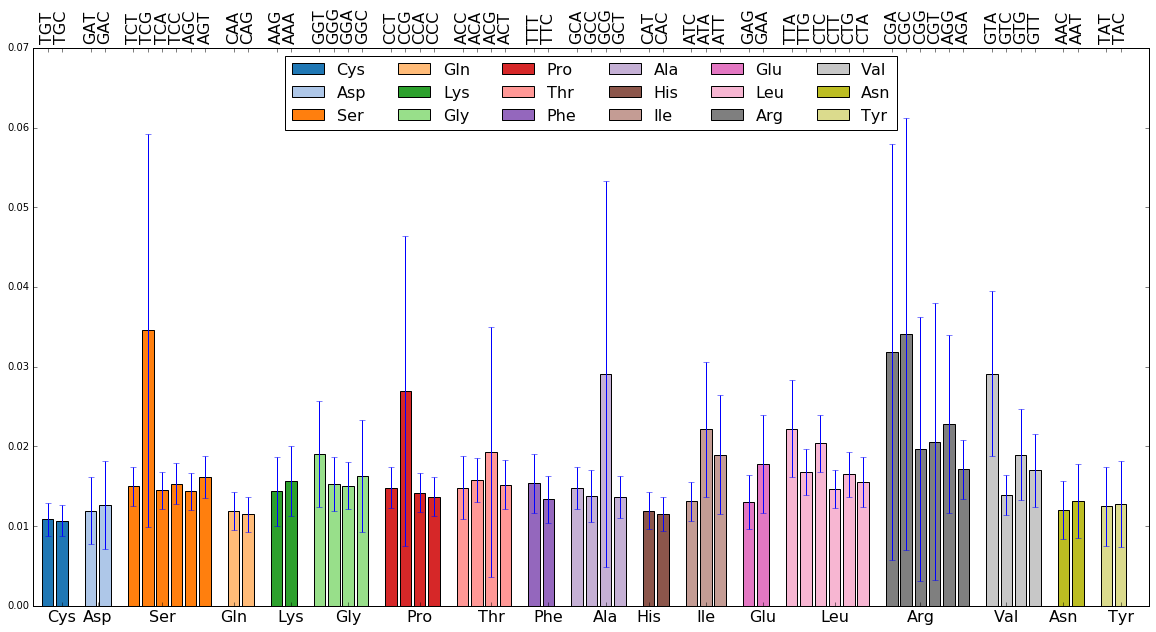

['CGA' 'CGC' 'CGG' 'CGT' 'AGG' 'AGA' 'TTA' 'TTG' 'CTC' 'CTT' 'CTG' 'CTA'
 'TCT' 'TCG' 'TCA' 'TCC' 'AGC' 'AGT' 'CCT' 'CCG' 'CCA' 'CCC' 'ACC' 'ACA'
 'ACG' 'ACT' 'GCA' 'GCC' 'GCG' 'GCT' 'GGT' 'GGG' 'GGA' 'GGC' 'GTA' 'GTC'
 'GTG' 'GTT' 'ATC' 'ATA' 'ATT' 'AAG' 'AAA' 'GAG' 'GAA' 'GAT' 'GAC' 'CAT'
 'CAC' 'TGT' 'TGC' 'CAA' 'CAG' 'TTT' 'TTC' 'TAT' 'TAC' 'AAC' 'AAT']


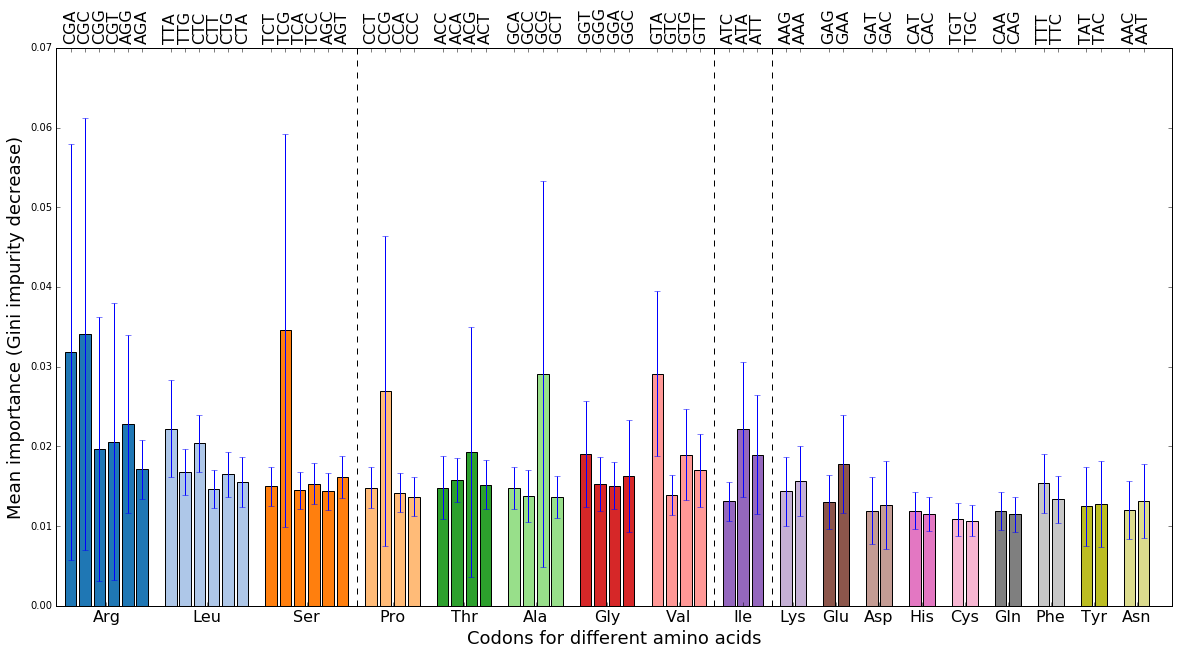

In [18]:
#PLEASE RUN THE PREVIOUS CELL FIRST - if fits the forest you are working with

importances = feature_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in feature_forest.estimators_],
             axis=0)
mean_imp = np.mean([tree.feature_importances_ for tree in feature_forest.estimators_],
             axis=0)
max_imp = np.max([tree.feature_importances_ for tree in feature_forest.estimators_],
             axis=0)
min_imp = np.min([tree.feature_importances_ for tree in feature_forest.estimators_],
             axis=0)

percentile_imp = np.percentile([tree.feature_importances_ for tree in feature_forest.estimators_],q=50,
             axis=0)

#indices = np.argsort(importances)[::-1] #DONT WANT TO SORT NOW
indices = range(len(importances))

# Print the feature ranking
#print("Feature ranking:")
#for f in range(X.shape[1]):
#    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")

#the followoing two are the same, just sanity check
#plt.bar(range(features.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.bar(range(features.shape[1]), mean_imp[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(features.shape[1]), indices)
plt.xlim([-1, features.shape[1]])
plt.show()

##
## We want to associate features with amoino acids, not just numbers from 0 to58

#dictionary to easily map
AA_to_Codons = {
'CYS': ['TGT', 'TGC'],
'ASP': ['GAT', 'GAC'],
'SER': ['TCT', 'TCG', 'TCA', 'TCC', 'AGC', 'AGT'],
'GLN': ['CAA', 'CAG'],
#'MET': ['ATG'],
'ASN': ['AAC', 'AAT'],
'PRO': ['CCT', 'CCG', 'CCA', 'CCC'],
'LYS': ['AAG', 'AAA'],
#'STOP': ['TAG', 'TGA', 'TAA'],
'THR': ['ACC', 'ACA', 'ACG', 'ACT'],
'PHE': ['TTT', 'TTC'],
'ALA': ['GCA', 'GCC', 'GCG', 'GCT'],
'GLY': ['GGT', 'GGG', 'GGA', 'GGC'],
'ILE': ['ATC', 'ATA', 'ATT'],
'LEU': ['TTA', 'TTG', 'CTC', 'CTT', 'CTG', 'CTA'],
'HIS': ['CAT', 'CAC'],
'ARG': ['CGA', 'CGC', 'CGG', 'CGT', 'AGG', 'AGA'],
#'TRP': ['TGG'],
'VAL': ['GTA', 'GTC', 'GTG', 'GTT'],
'GLU': ['GAG', 'GAA'],
'TYR': ['TAT', 'TAC']
}

#just the order of codons in our feature set
codons= ["Cys","Cys","Asp","Asp","Ser","Ser","Ser","Ser","Ser","Ser","Gln","Gln","Lys","Lys",
         "Gly","Gly","Gly","Gly","Pro","Pro","Pro","Pro","Thr","Thr","Thr","Thr","Phe","Phe",
         "Ala","Ala","Ala","Ala","His","His","Ile","Ile","Ile","Glu","Glu",
         "Leu","Leu","Leu","Leu","Leu","Leu","Arg","Arg","Arg","Arg","Arg","Arg",
         "Val","Val","Val","Val","Asn","Asn","Tyr","Tyr"]

#order of AA-s
AA_order = ["Cys","Asp","Ser","Gln","Lys","Gly","Pro","Thr","Phe",
                "Ala","His","Ile","Glu","Leu","Arg","Val","Asn","Tyr"]

## dictinoary to map AA to feature numbers
temporary="Cys"
aid=0
amino_id = [] #list of amino acid nrs
aminos=["Cys"]
amino_dict={"Cys":[]}
for i in range(59):
    if codons[i]==temporary:
        amino_id.append(aid)
        amino_dict[codons[i]].append(i)
    else:
        aid+=1
        amino_dict[codons[i]]=[i]
        temporary=codons[i]
        amino_id.append(aid)
        aminos.append(codons[i])
print amino_id,amino_dict


#plotting now:

fig=plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny() #the upper axis with codon names

x_axis = np.array(range(features.shape[1]))+amino_id #we give bars locations with AA-s separated


ax1.bar(x_axis, importances[indices],
       color=tableau20[amino_id,:], yerr=std[indices], align="center")
ax1.set_xticks([1,3.5,8,13,17,21,26,31,35,39,42,46,50,55,61,67,71,75]) #where AA names appear
ax1.set_xticklabels(aminos,fontsize=16)
ax1.set_xlim([-1, features.shape[1]+len(np.unique(amino_id))])

#legend is custom made:
import matplotlib.patches as mpatches
recs = []
for i in range(0,len(aminos)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=tableau20[i,:]))
plt.legend(recs,aminos,loc=9,ncol=6,fontsize=16)

#upper axis contains codon names
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(x_axis)
order_of_codons = np.concatenate([AA_to_Codons[x.upper()] for x in AA_order])

ax2.set_xticklabels(order_of_codons,fontsize=16, rotation="vertical")
plt.show()

####################################################################################

# change the order of amino acids to start with AA-s with more synonyms
plt.clf()
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

order_to_plot=["Arg","Leu","Ser","Pro","Thr","Ala","Gly",
               "Val","Ile","Lys","Glu","Asp","His",
               "Cys","Gln","Phe","Tyr","Asn"]

order_of_codons = np.concatenate([AA_to_Codons[x.upper()] for x in order_to_plot])
print order_of_codons

codon_ids = np.concatenate([amino_dict[x] for x in order_to_plot])
color_code = np.concatenate([[x]*len(amino_dict[order_to_plot[x]]) for x in range(18)])

#
ax1.bar(np.arange(59)+color_code, importances[codon_ids],
       color=tableau20[color_code,:], yerr=std[codon_ids], align="center")
ax1.set_xlim([-1, features.shape[1]+len(np.unique(amino_id))])
ax2.set_xlim([-1, features.shape[1]+len(np.unique(amino_id))])

ax1.axvline(20,color="black", linestyle="--")
ax1.axvline(45,color="black", linestyle="--")
ax1.axvline(49,color="black", linestyle="--")
ax1.set_xticks([2.5,9.5,16.5,22.5,27.5,32.5,37.5,42.5,47,50.5,53.5,56.5,59.5,62.5,65.5,68.5,71.5,74.5])
ax1.set_xticklabels(order_to_plot,fontsize=16)
ax1.set_xlabel("Codons for different amino acids",fontsize=18)
ax1.set_ylabel("Mean importance (Gini impurity decrease)",fontsize=18)

ax2.set_xticks(np.arange(59)+color_code)
ax2.set_xticklabels(order_of_codons, fontsize=16, rotation="vertical")
plt.show()

# Average feature values for the two classes 

(59,) (59,)


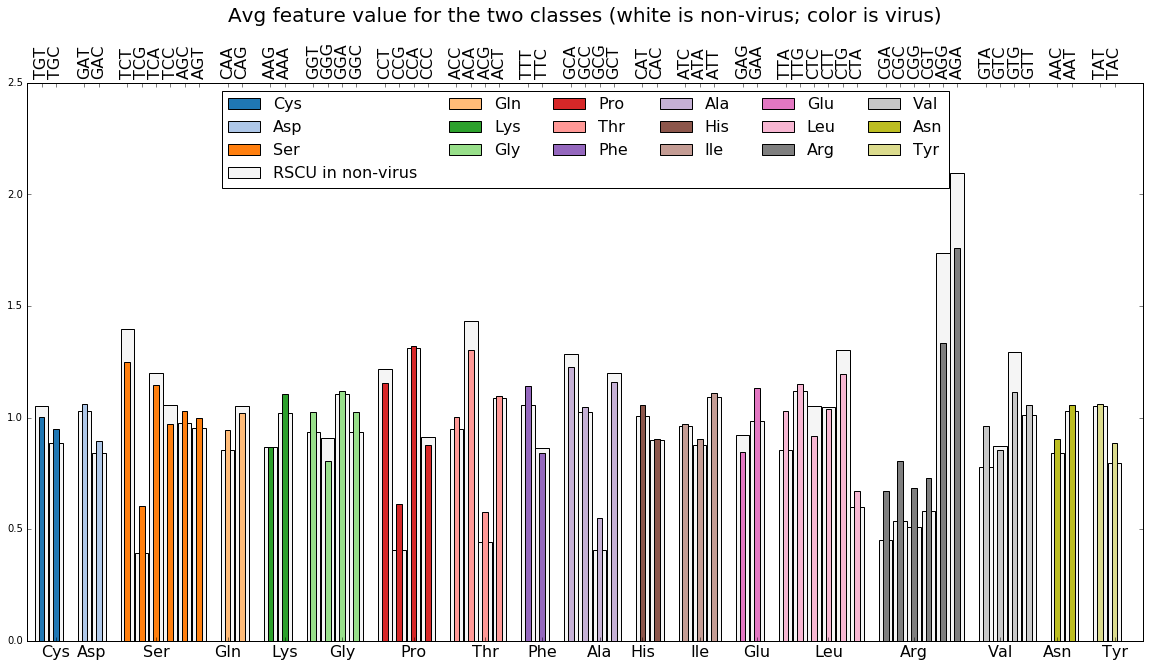

['CGA' 'CGC' 'CGG' 'CGT' 'AGG' 'AGA' 'TTA' 'TTG' 'CTC' 'CTT' 'CTG' 'CTA'
 'TCT' 'TCG' 'TCA' 'TCC' 'AGC' 'AGT' 'CCT' 'CCG' 'CCA' 'CCC' 'ACC' 'ACA'
 'ACG' 'ACT' 'GCA' 'GCC' 'GCG' 'GCT' 'GGT' 'GGG' 'GGA' 'GGC' 'GTA' 'GTC'
 'GTG' 'GTT' 'ATC' 'ATA' 'ATT' 'AAG' 'AAA' 'GAG' 'GAA' 'GAT' 'GAC' 'CAT'
 'CAC' 'TGT' 'TGC' 'CAA' 'CAG' 'TTT' 'TTC' 'TAT' 'TAC' 'AAC' 'AAT']
[ 0.45068043  0.53814638  0.39454328  0.4061283   0.40645649  0.77827236]
[ 0.66952607  0.80418381  0.60184143  0.61486067  0.55136935  0.96116854]






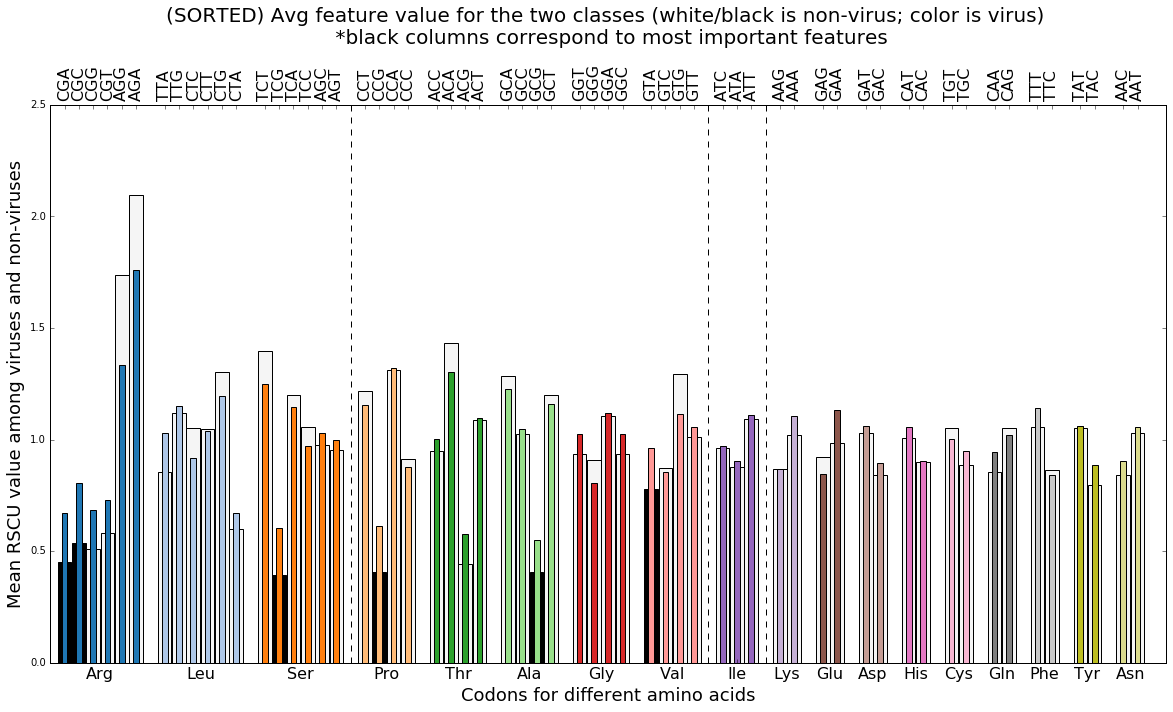

In [28]:
vir_feat = np.mean(features[np.where(labels==1)[0]],axis=0)
nonvir_feat = np.mean(features[np.where(labels==0)[0]],axis=0)
print np.shape(nonvir_feat), np.shape(vir_feat)

#print nonvir_feat
#print vir_feat


fig=plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny() #the upper axis with codon names

x_axis = np.array(range(features.shape[1])) +amino_id #we give bars locations with AA-s separated

ax1.bar(x_axis, nonvir_feat[indices],
       color="whitesmoke", width=0.95, align="center")
ax1.set_xticks([1,3.5,8,13,17,21,26,31,35,39,42,46,50,55,61,67,71,75]) #where AA names appear
ax1.set_xticklabels(aminos,fontsize=16)
ax1.set_xlim([-1, features.shape[1]+len(np.unique(amino_id))])

ax1.bar(x_axis, vir_feat[indices],
       color=tableau20[amino_id,:],width=0.4, align="center")
ax1.set_xticks([1,3.5,8,13,17,21,26,31,35,39,42,46,50,55,61,67,71,75]) #where AA names appear
ax1.set_xticklabels(aminos,fontsize=16)
ax1.set_xlim([-1, features.shape[1]+len(np.unique(amino_id))])



#legend is custom made:
import matplotlib.patches as mpatches
recs = []
for i in range(0,len(aminos)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=tableau20[i,:]))

plt.legend(recs[:3]+[mpatches.Rectangle((0,0),2,2,fc="whitesmoke")]+recs[3:],aminos[:3]+["RSCU in non-virus"]+aminos[3:],loc=9,ncol=6,fontsize=16)

#upper axis contains codon names
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(x_axis)
order_of_codons = np.concatenate([AA_to_Codons[x.upper()] for x in AA_order])

ax2.set_xticklabels(order_of_codons,fontsize=16, rotation="vertical")
plt.title("Avg feature value for the two classes (white is non-virus; color is virus)", y=1.1, fontsize=20)
plt.show()



#############################

# change the order of amino acids to start with AA-s with more synonyms
plt.clf()
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

order_to_plot=["Arg","Leu","Ser","Pro","Thr","Ala","Gly",
               "Val","Ile","Lys","Glu","Asp","His",
               "Cys","Gln","Phe","Tyr","Asn"]

order_of_codons = np.concatenate([AA_to_Codons[x.upper()] for x in order_to_plot])
print order_of_codons

codon_ids = np.concatenate([amino_dict[x] for x in order_to_plot])
color_code = np.concatenate([[x]*len(amino_dict[order_to_plot[x]]) for x in range(18)])

nonvir_bar_color= ["whitesmoke"]*59
special_color= "black"
nonvir_bar_color[0]= special_color
nonvir_bar_color[1]= special_color
nonvir_bar_color[13]= special_color
nonvir_bar_color[19]= special_color
nonvir_bar_color[28]= special_color
nonvir_bar_color[34]= special_color

importants=[0,1,13,19,28,34]
print nonvir_feat[codon_ids][importants]
print vir_feat[codon_ids][importants]

print "\n\n\n"
#
ax1.bar(np.arange(59)+color_code, nonvir_feat[codon_ids], width=0.95,
       color=nonvir_bar_color, align="center")

ax1.bar(np.arange(59)+color_code, vir_feat[codon_ids], width=0.4,
       color=tableau20[color_code,:], align="center")

ax1.set_xlim([-1, features.shape[1]+len(np.unique(amino_id))])
ax2.set_xlim([-1, features.shape[1]+len(np.unique(amino_id))])

ax1.axvline(20,color="black", linestyle="--")
ax1.axvline(45,color="black", linestyle="--")
ax1.axvline(49,color="black", linestyle="--")
ax1.set_xticks([2.5,9.5,16.5,22.5,27.5,32.5,37.5,42.5,47,50.5,53.5,56.5,59.5,62.5,65.5,68.5,71.5,74.5])
ax1.set_xticklabels(order_to_plot,fontsize=16)
ax1.set_xlabel("Codons for different amino acids",fontsize=18)
ax1.set_ylabel("Mean RSCU value among viruses and non-viruses",fontsize=18)

ax2.set_xticks(np.arange(59)+color_code)
ax2.set_xticklabels(order_of_codons, fontsize=16, rotation="vertical")
plt.title("(SORTED) Avg feature value for the two classes (white/black is non-virus; color is virus) \n *black columns correspond to most important features", y=1.1, fontsize=20)

plt.show()

### At some point we wanted to know if more frequent synonym is the more important one -it is not

In [29]:
#HOW FREQUENT ARE THE IMPORTANT CODONS??

frequency={}
order_of_codons = np.concatenate([AA_to_Codons[x.upper()] for x in AA_order])

for i in range(59):
    frequency[order_of_codons[i]] = np.mean(features,axis=0)[i]

##'PRO': ['CCT', 'CCG', 'CCA', 'CCC'],
print frequency["CCG"], "  vs  ", frequency["CCT"],frequency["CCA"],frequency["CCC"]


#'SER': ['TCT', 'TCG', 'TCA', 'TCC', 'AGC', 'AGT'],
print frequency["TCG"], "  vs  ", frequency["TCT"],frequency["TCA"],frequency["TCC"],frequency["AGC"],frequency["AGT"]


0.412397982026   vs   1.21426455452 1.31196233379 0.911662215386
0.40076988569   vs   1.39375392244 1.19834379051 1.05272559719 0.979022010732 0.952670190137


## --------------------------------------------------------------
## ANALYSING RESULTS FROM NEURAL NETS
## --------------------------------------------------------------

In [30]:
NN_predictions = []
NN_probas = []
NN_labels = []
for i in range(19):
    if i==5:
        pass
    else:
        matrix = np.loadtxt("final_LOEO_cw/LOEO_predictions_"+str(i)+".txt",dtype=float)
        NN_probas.append(matrix[:,1])
        NN_labels.append(np.array(matrix[:,3],dtype=int))
        NN_predictions.append(np.argmax(matrix[:,:2],axis=1))
        
#testing read-in
print NN_predictions[0][20:30],NN_probas[0][20:30]

#testing if NN output agrees
print classification_report(NN_labels[0],NN_predictions[0], target_names=["not virus", "virus"])
print np.shape(NN_labels),np.shape(NN_probas),np.shape(NN_predictions)



[0 0 0 0 0 0 0 0 0 0] [ 0.023  0.     0.     0.     0.054  0.016  0.     0.005  0.072  0.015]
             precision    recall  f1-score   support

  not virus       0.95      1.00      0.97     13649
      virus       0.87      0.30      0.45       985

avg / total       0.95      0.95      0.94     14634

(18,) (18,) (18,)


In [31]:
NN_all_labels = np.concatenate(NN_labels)
NN_all_probas = np.concatenate(NN_probas)
NN_all_preds = np.concatenate(NN_predictions)

print NN_all_labels.shape,  NN_all_preds.shape, np.unique(NN_all_preds), type(NN_labels)

#NN_all_labels = np.array(NN_all_labels,dtype=int)
report = classification_report(NN_all_labels, NN_all_preds, target_names=["not virus", "virus"])
print "Micro-average report at 0.5: \n", report

NN_precisions_per_experiment=[]
NN_recalls_per_experiment=[]

for i in range(len(NN_labels)):
    NN_precisions_per_experiment.append(precision_score(NN_labels[i],np.array(NN_probas[i]>0.5,dtype=int),average=None))
    NN_recalls_per_experiment.append(recall_score(NN_labels[i],np.array(NN_probas[i]>0.5,dtype=int),average=None))

NN_precisions_per_experiment=np.array(NN_precisions_per_experiment)
NN_recalls_per_experiment=np.array(NN_recalls_per_experiment)

print "virus precisions per experiment look correct: ", NN_precisions_per_experiment[:,1]
print "virus recalls per experiment look correct: ", NN_recalls_per_experiment[:,1]

print "Macro-average precisions: [non virus, virus]: ", np.mean(NN_precisions_per_experiment,axis=0)
print "Macro-average recalls: [non virus, virus]: ",np.mean(NN_recalls_per_experiment,axis=0)


(188179,) (188179,) [0 1] <type 'list'>
Micro-average report at 0.5: 
             precision    recall  f1-score   support

  not virus       0.97      0.99      0.98    182514
      virus       0.39      0.18      0.25      5665

avg / total       0.96      0.97      0.96    188179

virus precisions per experiment look correct:  [ 0.87058824  0.06666667  0.43243243  0.          0.43076923  0.35820896
  0.29661017  0.06666667  0.31884058  0.52058111  0.82926829  0.275
  0.08571429  0.26923077  0.0591133   0.10045662  0.57142857  0.21319797]
virus recalls per experiment look correct:  [ 0.30050761  0.02702703  0.04878049  0.          0.09003215  0.20168067
  0.11864407  0.26666667  0.42409639  0.49768519  0.30357143  0.07189542
  0.07692308  0.3255814   0.06666667  0.01516196  0.28571429  0.15      ]
Macro-average precisions: [non virus, virus]:  [ 0.96554211  0.32026521]
Macro-average recalls: [non virus, virus]:  [ 0.98868276  0.18170192]


Area under the MICRO curve is: 0.768028835685
AREA UNDER MACRO SEEMS TO BE 0.768395854366
at precision 0,75    0.750554323725 0.119505736981
0.900651465798 0.0976169461606
0.950787401575 0.0852603706973


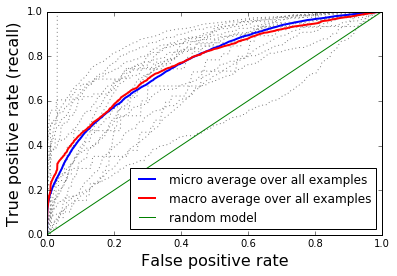

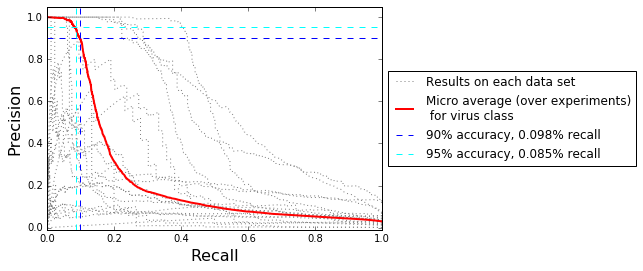

AREA UNDER precision rec SEEMS TO BE 0.233114379336


In [32]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from scipy import interp


areas=[]
counts=[]
FP_rates=[]
TP_rates=[]

for i in range(18):
    #print np.shape(roc_labels[0]),np.shape(roc_probas[0][:,1])
    fpr,tpr,thresh = roc_curve(NN_labels[i],NN_probas[i])
    FP_rates.append(fpr)
    TP_rates.append(tpr)
    
    #print roc_auc_score(roc_labels[i],roc_probas[i][:,1])
    plt.plot(fpr,tpr,color="gray",linestyle="dotted")
    areas.append(roc_auc_score(NN_labels[i],NN_probas[i]))
    counts.append(len(NN_labels[i]))


fpr,tpr,thresh = roc_curve(NN_all_labels,NN_all_probas)
plt.plot(fpr,tpr,linewidth=2,label="micro average over all examples",color="blue")


# Compute macro-average ROC curve and ROC area
n_experiments=18
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([FP_rates[i] for i in range(n_experiments)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_experiments):
    mean_tpr += interp(all_fpr, FP_rates[i], TP_rates[i])

# Finally average it and compute AUC
mean_tpr /= n_experiments
plt.plot(all_fpr,mean_tpr,linewidth=2,label="macro average over all examples",color="red")


plt.ylabel("True positive rate (recall)",fontsize=16)
plt.xlabel("False positive rate",fontsize=16)
plt.plot([0,1],[0,1], label="random model",color="green")
plt.legend(loc=4)


print "Area under the MICRO curve is:", roc_auc_score(NN_all_labels,NN_all_probas)


from sklearn.metrics import auc
print "AREA UNDER MACRO SEEMS TO BE", auc(all_fpr, mean_tpr)

#
#-----------------------------------------------------------------------------
#

fig = plt.figure()
ax = plt.subplot(111)

experiment_v_precs=[]
experiment_v_recs=[]
experiment_nv_precs=[]
experiment_nv_recs=[]
for i in range(18):
    prec_v,rec_v,thresh = precision_recall_curve(NN_labels[i],NN_probas[i])
    prec_nv,rec_nv,thresh = precision_recall_curve(np.abs(NN_labels[i]-1), 1-NN_probas[i])
    experiment_v_precs.append(prec_v)
    experiment_v_precs.append(rec_v)
    experiment_nv_precs.append(prec_nv)
    experiment_nv_recs.append(rec_nv)

    ax.plot(rec_v,prec_v,color="gray",linestyle="dotted")
    #areas.append(roc_auc_score(roc_labels[i],roc_probas[i][:,1]))
    #counts.append(len(roc_labels[i]))

ax.plot(rec_v,prec_v,color="gray",linestyle="dotted",label="Results on each data set")

    
precision_vir,recall_vir,thresh = precision_recall_curve(NN_all_labels,NN_all_probas)
ax.plot(recall_vir,precision_vir,color="red",label="Micro average (over experiments)\n for virus class",linewidth=2)
ax.set_xlabel('Recall',fontsize=16)
ax.set_ylabel('Precision',fontsize=16)
ax.set_ylim([-0.01, 1.05])
ax.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax.set_xlim([0.0, 1.0])
#plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision[0]))

id82 = np.min(np.where(precision_vir>0.75)[0])
print "at precision 0,75   ", precision_vir[id82],recall_vir[id82]

id90 = np.min(np.where(precision_vir>0.9)[0])
print precision_vir[id90],recall_vir[id90]
id95 = np.min(np.where(precision_vir>0.95)[0])
print precision_vir[id95],recall_vir[id95]
ax.axhline(precision_vir[id90],linestyle="--",label="90% accuracy, "+str(np.round(recall_vir[id90],3))+"% recall")
ax.axvline(recall_vir[id90],linestyle="--")
ax.axhline(precision_vir[id95],color="cyan",linestyle="--",label="95% accuracy, "+str(np.round(recall_vir[id95],3))+"% recall")
ax.axvline(recall_vir[id95],color="cyan",linestyle="--")
ax.legend(loc="center left",bbox_to_anchor=(1,0.5))

plt.show()


print "AREA UNDER precision rec SEEMS TO BE", auc(recall_vir, precision_vir)
